In [1]:
import torch
from torch import nn
from torch.utils.data import random_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms
from alg.vcl_net import MultiHeadVCLSplitNotMNIST, Initialization
from alg.kcenter import KCenter
import os, tarfile

In [2]:
tar_file = './data/notMNIST_small.tar.gz'
folder = './data/notMNIST_small'
if not os.path.exists(folder):
    if not os.path.exists(tar_file):
        raise Exception("notMNIST dataset is missing, download at: https://www.kaggle.com/datasets/lubaroli/notmnist")
    with tarfile.open(tar_file) as f:
        f.extractall('./data/')
    assert os.path.exists(folder), "Something went wrong with extraction."

# these are some empty images
empty_files = ['A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png', 'F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png']
for file_name in empty_files:
    file_name = f"{folder}/{file_name}"
    if os.path.exists(file_name):
        os.remove(file_name)


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

image_folder = ImageFolder(folder, transform=transform)

# Same split ratio as in MNIST
train, test = random_split(image_folder, [1 - 0.143, 0.143], generator=torch.Generator().manual_seed(0))
def get_sNonMNIST(task_idx, device):
    # "The notMNIST dataset contains 400,000 images of the characters from 
    #  A to J with different font styles. We consider ﬁve binary classiﬁcation 
    #  tasks: A/F, B/G, C/H, D/I, and E/J"
    np.random.seed(task_idx)

    labels = (task_idx, task_idx + 5) # labels are 0 to 9 for A to J in order
    ds_train_filtered = list(filter(lambda item: item[1] in labels, train))
    ds_test_filtered = list(filter(lambda item: item[1] in labels, test))
    train_x = nn.Flatten()(torch.cat([d[0] for d in ds_train_filtered]))
    train_y = torch.tensor([0 if d[1] == task_idx else 1 for d in ds_train_filtered])
    
    test_x = nn.Flatten()(torch.cat([d[0] for d in ds_test_filtered]))
    test_y = torch.tensor([0 if d[1] == task_idx else 1 for d in ds_test_filtered])

    return train_x.to(device), train_y.to(device), test_x.to(device), test_y.to(device)

In [3]:
def run(verbose=True):
    device = 'cuda'

    test_x_all = []
    test_y_all = []
    test_task_i_all = []

    coreset_x = None
    coreset_y = None
    coreset_size = 40

    batch_size = 1000000 # "batch size equal to the size of the training set"

    random_coreset = True
    accuracies = []
    n_epochs = 120

    previous_model, coreset_task_mask = None, None
    for task_i in range(5):
        train_x, train_y, test_x, test_y = get_sNonMNIST(task_i, device)
        test_x_all.append(test_x)
        test_y_all.append(test_y)
        test_task_i_all.append(torch.ones((test_x.shape[0]), dtype=int) * task_i)

        # define current model
        if task_i == 0:
            current_model = MultiHeadVCLSplitNotMNIST(num_heads=1, initialization=Initialization.RANDOM).to(device)
            current_model.set_prior(MultiHeadVCLSplitNotMNIST(num_heads=1, initialization=Initialization.DEFAULT).to(device))
        else:
            current_model = MultiHeadVCLSplitNotMNIST.new_from_prior(previous_model)
            current_model.add_head(initialization=Initialization.RANDOM)
            # Set last head the same as the first head (this was in the initial implementation in tf) TODO investigate
            # current_model.heads[-1].set_params(*previous_model.heads[0].get_params())
        assert len(current_model.heads) == task_i + 1
        current_opt = torch.optim.Adam(current_model.parameters(), lr=0.001)

        if random_coreset:
            coreset_idx = np.random.choice(train_x.shape[0], coreset_size, False)
        else:
            coreset_idx = np.array(KCenter(coreset_size).fit_transform(train_x.cpu().detach().numpy()))
        train_idx = np.delete(np.arange(train_x.shape[0]), coreset_idx)
        new_coreset_x = train_x[coreset_idx]
        new_coreset_y = train_y[coreset_idx]
        new_coreset_task_mask = torch.ones((new_coreset_x.shape[0]), dtype=int) * task_i
        train_x = train_x[train_idx]
        train_y = train_y[train_idx]

        if coreset_x == None:
            coreset_x = new_coreset_x
            coreset_y = new_coreset_y
            coreset_task_mask = new_coreset_task_mask
        else:
            coreset_x = torch.cat([new_coreset_x, coreset_x])
            coreset_y = torch.cat([new_coreset_y, coreset_y])
            coreset_task_mask = torch.cat([new_coreset_task_mask, coreset_task_mask])
            # "For all the algorithms with coresets, we choose 40 examples from each task to include into the coresets"

        ELBO = []
        for epoch in (tqdm if verbose else iter)(range(n_epochs)):
            ELBO_batch = []
            kl_batch = []
            log_pred_batch = []
            for batch in range(int(np.ceil(train_x.shape[0] / batch_size))):
                batch_idx0 = batch * batch_size
                batch_idx1 = batch * batch_size + batch_size
                current_opt.zero_grad()
                elbo = current_model.calculate_ELBO(x=train_x[batch_idx0: batch_idx1], 
                                                    y=train_y[batch_idx0: batch_idx1], 
                                                    n_particles=1,
                                                    task_i_mask=task_i,
                                                    dataset_size=train_x.shape[0])
                elbo.backward()
                nn.utils.clip_grad_value_(current_model.parameters(), 5)
                current_opt.step()
                ELBO_batch.append(elbo.item())
            ELBO.append(np.mean(ELBO_batch))
        if verbose:
            plt.plot(ELBO)
            plt.yscale("log")
            plt.show()

        test_x_tensor = torch.cat(test_x_all)
        test_y_tensor = torch.cat(test_y_all)
        test_task_i_mask_tensor = torch.cat(test_task_i_all)
        pred_y = []
        with torch.no_grad():
            for batch in range(int(np.ceil(test_x_tensor.shape[0] / batch_size))):
                batch_idx0 = batch * batch_size
                batch_idx1 = batch * batch_size + batch_size
                pred_logit_samples = nn.Softmax(-1)(torch.stack(current_model.predict(test_x_tensor[batch_idx0:batch_idx1], test_task_i_mask_tensor[batch_idx0:batch_idx1], 100), 0)).mean(0)
                pred_y.append(pred_logit_samples.argmax(-1))
            pred_y = torch.cat(pred_y)
            acc = (pred_y == test_y_tensor).cpu().numpy().mean()
        if verbose:
            print("Accuracy by the propagation model is %.4f"%acc)
            


        # calculate prediction model
        pred_model = MultiHeadVCLSplitNotMNIST.new_from_prior(current_model)
        pred_opt = torch.optim.Adam(pred_model.parameters(), lr=0.001)

        ELBO = []
        for epoch in (tqdm if verbose else iter)(range(n_epochs)):
            ELBO_batch = []
            for batch in range(int(np.ceil(coreset_x.shape[0] / batch_size))):
                batch_idx0 = batch * batch_size
                batch_idx1 = batch * batch_size + batch_size
                pred_opt.zero_grad()
                elbo = pred_model.calculate_ELBO(x=coreset_x[batch_idx0: batch_idx1], 
                                                y=coreset_y[batch_idx0: batch_idx1], 
                                                task_i_mask=coreset_task_mask[batch_idx0: batch_idx1],
                                                n_particles=1,
                                                dataset_size=coreset_x.shape[0])
                elbo.backward()
                nn.utils.clip_grad_value_(pred_model.parameters(), 5)
                pred_opt.step()
                ELBO_batch.append(elbo.item())
            ELBO.append(np.mean(ELBO_batch))
        if verbose:
            plt.plot(ELBO)
            plt.show()

        test_x_tensor = torch.cat(test_x_all)
        test_y_tensor = torch.cat(test_y_all)
        test_task_i_mask_tensor = torch.cat(test_task_i_all)
        pred_y = []
        with torch.no_grad():
            for batch in range(int(np.ceil(test_x_tensor.shape[0] / batch_size))):
                batch_idx0 = batch * batch_size
                batch_idx1 = batch * batch_size + batch_size
                pred_logit_samples = nn.Softmax(-1)(torch.stack(pred_model.predict(test_x_tensor[batch_idx0:batch_idx1], test_task_i_mask_tensor[batch_idx0:batch_idx1], 100), 0)).mean(0)
                pred_y.append(pred_logit_samples.argmax(-1))
            pred_y = torch.cat(pred_y)
            acc = (pred_y == test_y_tensor).cpu().numpy().mean()
        accuracies.append(acc)
        if verbose:
            print("Task {:d}, Accuracy: {:.4f}".format(task_i, acc))
        previous_model = current_model
    return accuracies
accs = [run(False) for _ in tqdm(range(10), desc='Running experiment')]

Running experiment: 100%|██████████| 10/10 [05:50<00:00, 35.09s/it]


Accuracies: [0.98219462 0.97149901 0.97190722 0.96184527 0.95924542] Average: 0.9693383075919099


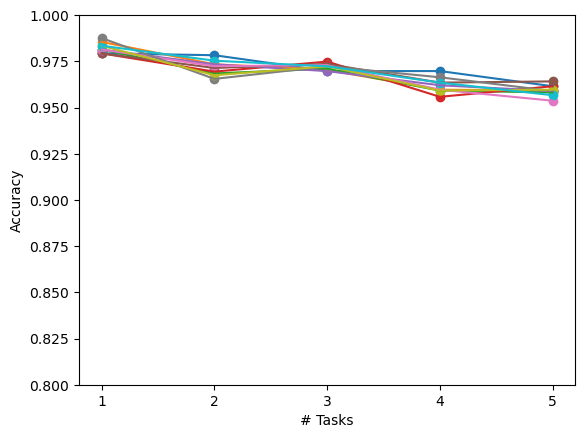

In [4]:
accuracies = np.array(accs)
print("Accuracies:", accuracies.mean(axis=0), "Average:", np.mean(accuracies))
for values in accs:
    plt.plot(np.arange(1, 6), values)
    plt.scatter(np.arange(1, 6), values)
    plt.xticks(np.arange(1, 6))
    plt.ylim(0.8, 1)
    plt.xlabel("# Tasks")
    plt.ylabel("Accuracy");